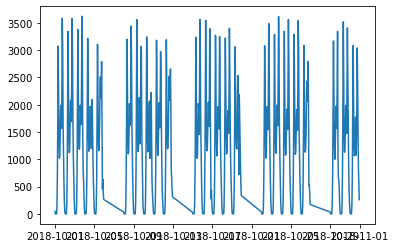

C:\Users\eduar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\eduar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\eduar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\eduar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an int

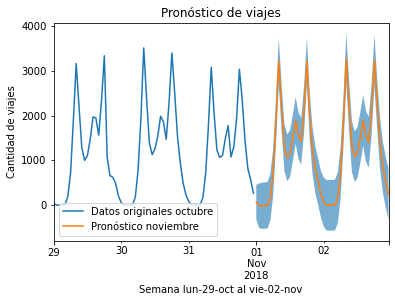

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
viajes = pd.read_csv('../csv/2018-10.csv')

# concatenar Hora_Retiro y Fecha_Retiro
viajes['fecha_hora_retiro'] = viajes.Fecha_Retiro + ' ' + viajes.Hora_Retiro

# cambiar de str a datetime
viajes['fecha_hora'] = viajes.fecha_hora_retiro \
                             .map(lambda x : datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))

# reindexar el dataframe
viajes.index = viajes.fecha_hora

# limpiar valores de otros años
viajes = viajes.loc['2018-10']

# resample y agregacion por dia de mes
viajes_resample_day = viajes.Bici.resample('H').count()

# asignar día de la semana
df_resample = pd.concat([viajes_resample_day], axis=1)
df_resample['dayofweek'] = df_resample.index.dayofweek # 0 es lunes

# lunes a viernes
df_mon_to_fri = df_resample[df_resample.dayofweek.isin([0,1,2,3,4])].Bici
plt.plot(df_mon_to_fri)
plt.show()

# definir conjunto de datos
x = df_mon_to_fri

# instanciar modelo
sarima_model = SARIMAX(x, order=(2,0,1), seasonal_order=(2, 1, 0, 24))

# ajustar modelo
results = sarima_model.fit()

# mirar el AIC
results.aic

# tomar de datos originales dias 29-oct, 30-oct, y 31-oct
df_29_31 = df_mon_to_fri.loc['2018-10-29':'2018-10-31']
df_29_31.plot()

# agregar bandas de confianza
pred_1_2_conf = results.get_forecast(steps=24*2).conf_int()
pred_1_2_conf.index = pd.date_range(start='11/1/2018', end='11/3/2018', freq='H')[:-1]
x = pd.date_range(start='11/1/2018', end='11/3/2018', freq='H')[:-1]
y1 = pred_1_2_conf['lower Bici']
y2 = pred_1_2_conf['upper Bici']
plt.fill_between(x, y1, y2, alpha=0.6)

# predecir para 1-nov y 2-nov
pred_1_2 = results.get_forecast(steps=24*2).predicted_mean
pred_1_2.index = pd.date_range(start='11/1/2018', end='11/3/2018', freq='H')[:-1]
pred_1_2.plot()

# formato de la grafica final
plt.title('Pronóstico de viajes')
plt.ylabel('Cantidad de viajes')
plt.xlabel('Semana lun-29-oct al vie-02-nov')
plt.legend(('Datos originales octubre', 'Pronóstico noviembre'),
           loc='lower left')
plt.savefig('pronostico.png')
plt.show()